# Relatório Projeto 3 - CUDA - Supercomp 2019.2
### Frederico Vilela Curti
___

## Descrição do problema tratado

O problema tratado nesse projeto é o problema do Caixeiro Viajante, no qual, de forma lúdica, um vendedor possui uma lista de empresas que ele deverá visitar ao longo do dia, e não existe uma ordem para tal. Desde que todas as empresas sejam visitadas, o objetivo do dia está cumprido. Para otimizar esse percurso e passar o maior tempo possível com seus clientes, ele precisa encontrar uma rota que resulta no menor caminho percorrido ao final do dia. Nesse problema, as empresas serão representadas por pontos em um plano. O desafio desse projeto era implementar uma solução capaz de utilizar da GPU(CUDA) para computar esse percurso de maneira extremamente eficiente, fazendo proveito do imenso poder de paralelismo oferecido por tais dispositivos.

## Organização em alto nível do projeto.

O projeto foi escrito em CUDA C. Foram desenvolvidas duas soluções para efeito de comparação: A solução `2opt` e a solução `random`, na qual a `2opt` é uma otimização da `random`.

Existem diferenças notáveis entre código executado na CPU e GPU. A primeira é uma limitação de tamanho, onde a GPU(CUDA) exige que o problema seja dividido em blocos que serão computados em um `kernel`, nos quais cada bloco da GPU pode executar até 1024 threads. No código, esse kernel é representado por uma função com o prefixo `__global__`, enquanto funções auxiliares, que podem ser chamadas dentro do kernel, possuem o prefixo `__device__`. 

Para otimizar o problema, em comparação ao Projeto 2, foi feito um pré-calculo das distâncias entre cada ponto em uma matriz N * N, no qual o indice de cada linha representa um ponto e a coluna outro. Isso evita que a distância entre os pontos seja computada em cada iteração. O kernel que pré-computa as distâncias foi chamado de `distKernel`. O que calcula as soluções é o `solKernel`. 

Na solução `random`, o kernel gera várias entradas de 0 a N, que são permutadas em índices gerados aleatóriamente por cada thread para gerar um caminho aleatório. Esse caminho é armazenado no vetor em GPU `d_solutions` e tem seu custo calculado e adicionado em um vetor na GPU chamado `d_costs`. Em seguida, é usada a biblioteca `thrust` com a função `min_element` para achar o menor custo gerado, e a partir do índice desse custo é possível exibir qual foi o caminho que gerou esse custo. Essa solução não produz um resultado ótimo, porém é de execução rápida e com um número de soluções aleatórias alto pode se aproximar de uma solução viável.

A solução `2opt` é uma otimização solução anterior, com o princípio de que caminhos que se cruzam inerentemente produzirão um custo maior. Para aplicar esse princípio de maneira inocente, basta tentar "desfazer" esses cruzamentos, trocando pares de nós (com a função em GPU `swap`) e re-calculando a distância da solução (função `cost`). Caso exista uma melhora com uma troca, a mesma é mantida. Caso contrário, a troca é desfeita. Esse processo leva um pouco mais de tempo do que a solução puramente aleatória, porém deve produzir resultados superiores em tempo hábil. O menor custo é encontrado da mesma forma que a solução `random`, com o `thrust::min_element`, que busca esse elemento de maneira paralela na GPU.

Essas entradas representam um conjunto de *N* pontos e seguem o seguinte formato:


```
N
x_0 y_0
x_1 y_1
....
x_(N-1) y_(N-1)
```

Onde:

* `N` é o número de pontos do problema.
- Cada linha subsequente contém um ponto com as seguintes propriedades:
    * coordenada no eixo x `x_N`
    * coordenada no eixo y `y_N`

Quando lidos, as coordenadas de cada ponto são armazenados em um `struct point` e armazenadas em um `thrust::host_vector<point>`, que será copiado para a GPU antes de iniciar os cálculos (`thrust::device_vector<point> d_points(h_points)`). Essa operação de cópia dos dados para a GPU leva tempo, que será mensurado no benchmark com auxilio da ferramenta `nvprof`. 

A solução em CPU foi implementada com auxílio da biblioteca `OpenMP`, que fornece blocos estruturados e diretrizes de compilação (`#pragma omp`) com ferramentas para a execução paralela de código distribuído no número de threads determinado pela variável de ambiente `OMP_NUM_THREADS`. 

O formato de saída será:
```
dist opt
0 e_1 ... e_(N-1)
```

Onde:

- `dist` é o comprimento do caminho encontrado usando 5 casas decimais.
- `e_1 ... e_(N-1)` é a sequência de empresas visitadas no trajeto
- `opt` é `1` se a solução encontrada é a ótima e `0` se foi usada outra estratégia

## Benchmark
Foram criadas 3 versões, todas usando a flag -O3 para as seguintes versões do algoritmo:

- GPU - Random
- GPU - 2Opt
- CPU - Branch and Bound (BB) 

#### O sistema no qual esse benchmark foi executado possui as seguintes configurações:

- CPU: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
- GPU: Tesla K80 12GB
- RAM: 64 GB
- SO: Amazon Linux 2

In [8]:
KEY_PATH = "../IgorNvidia.pem"
IP = '204.236.254.145'

In [9]:
# Importando dependências
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import paramiko

In [63]:
client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(IP, username='ec2-user', pkey=paramiko.RSAKey.from_private_key_file(KEY_PATH))

# Descrição dos testes feitos
Os testes abaixo foram realizados com um pipe ssh na máquina remota. Todas as entradas foram geradas com o gerador do projeto 2 `gerador.py`. Como a solução que só usa CPU leva muito mais tempo, as entradas são menores (8, 12, 14 e 16 pontos). As soluções em CUDA usam entradas do de tamanho 32, 64, 128 e 256 pontos.

Por questão de tempo, só foi realizada uma única execução de cada programa, o que pode ser alterado na constante `TESTS_PER_EXECUTABLE`.

O número de soluções geradas pelo kernel está na constante `SOLUTIONS`, e terá como valor padrão `10000`.

O tempo da versão em CPU com OpenMP é mensurado com a biblioteca `chrono`, usando o `high_resolution_clock`, que ao término da simulação é impresso na saída de erros *(stderr)*, para ser capturado pelo código de benchmark. Nas soluções que usam GPU, o tempo foi mensurado com os eventos CUDA através da função `cudaEventElapsedTime`, também impresso na saída de erros. A solução em CPU usada será a **branch and bound**, que mesmo muito mais eficiente do que uma implementação ingênua, ainda fica longe em termos de desempenho quando comparada às soluções em GPU. 


Todos os testes são armazenados em um DataFrame do Pandas para análise grafica.

In [64]:
df = pd.DataFrame()

In [65]:
def cmd(exe, solutions, test):
    return f'cd fred/projeto3/build; ./{exe} {solutions} < ../input/{test}'

In [66]:
TESTS_PER_EXECUTABLE = 1
SOLUTIONS = 10000
INPUTS = ['in32.txt', 'in64.txt', 'in128.txt', 'in256.txt']
INPUTS_CPU = ['in8.txt', 'in12.txt', 'in14.txt', 'in16.txt']

EXECUTABLES = ['random-sol', '2opt-sol', 'cpu-sol']
df = pd.DataFrame()

# Inputs suitable for GPU
for exe in EXECUTABLES[:2]:
    for test in INPUTS:
        for i in range(TESTS_PER_EXECUTABLE):
            print('working:', exe, test)
            command = cmd(exe, SOLUTIONS, test)
            stdin, stdout, stderr = client.exec_command(command)
            time = float(stderr.readline().split()[0])
            cost = float(stdout.readline().split()[0])
            path = stdout.readline()
            df = df.append({
                'version': exe,
                'N': int(test.replace('in', '').replace('.txt', '')),
                'duration': time,
                'cost': cost,
                'path': path
            }, ignore_index=True)

working: random-sol in32.txt
working: random-sol in64.txt
working: random-sol in128.txt
working: random-sol in256.txt
working: 2opt-sol in32.txt
working: 2opt-sol in64.txt
working: 2opt-sol in128.txt
working: 2opt-sol in256.txt


In [71]:
# Inputs suitable for CPU
for exe in EXECUTABLES:
    for test in INPUTS_CPU:
        for i in range(TESTS_PER_EXECUTABLE):
            print('working:', exe, test)
            command = cmd(exe, SOLUTIONS, test)
            stdin, stdout, stderr = client.exec_command(command)
            time = float(stderr.readline().split()[0])
            cost = float(stdout.readline().split()[0])
            path = stdout.readline()
            df = df.append({
                'version': exe,
                'N': int(test.replace('in', '').replace('.txt', '')),
                'duration': time,
                'cost': cost,
                'path': path
            }, ignore_index=True)

working: random-sol in8.txt
working: random-sol in12.txt
working: random-sol in14.txt
working: random-sol in16.txt
working: 2opt-sol in8.txt
working: 2opt-sol in12.txt
working: 2opt-sol in14.txt
working: 2opt-sol in16.txt
working: cpu-sol in8.txt
working: cpu-sol in12.txt
working: cpu-sol in14.txt
working: cpu-sol in16.txt


## NVprof
É importante ressaltar que o tempo mensurado foi somente da execução dos *kernels* do problema, existe um overhead de tempo que não foi citado mas que deve ser mencionado, especialmente para entradas menores ou muito grandes, que é a cópia prévia dos dados para a GPU. Nessa solução foram usados vetores da biblioteca `thrust` que abstraem a difícil alocação de memória em GPU. A execução da ferramenta NVprof nos permite observar a divisão de trabalho e tempo na GPU. Como exemplo, a seguir está a distribuição de carga para uma entrada com 128 pontos na solução `2opt`

In [101]:
command = 'cd fred/projeto3/build && nvprof ./2opt-sol 10000 < ../input/in128.txt'
stdin, stdout, stderr = client.exec_command(command)
nvprof_out = ''
for line in stderr:
    nvprof_out += line

In [102]:
print('\n'.join(nvprof_out.split('\n')[:9]))

==13980== NVPROF is profiling process 13980, command: ./2opt-sol 10000
8485.52 ms
==13980== Profiling application: ./2opt-sol 10000
==13980== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  8.47871s         1  8.47871s  8.47871s  8.47871s  solKernel(double*, double*, int*, int, int)
                    0.00%  289.18us       130  2.2240us  2.0800us  3.4880us  [CUDA memcpy DtoH]
                    0.00%  49.568us         1  49.568us  49.568us  49.568us  void thrust::cuda_cub::core::_kernel_agent<thrust::cuda_cub::__parallel_for::ParallelForAgent<thrust::cuda_cub::__uninitialized_fill::functor<thrust::device_ptr<int>, int>, unsigned long>, thrust::cuda_cub::__uninitialized_fill::functor<thrust::device_ptr<int>, int>, unsigned long>(thrust::device_ptr<int>, int)
                    0.00%  21.792us         1  21.792us  21.792us  21.792us  distKernel(point*, double*, int)


Como pode-se observar, quase 100% do tempo foi gasto na execução do `solKernel`, equivalente à `8.47871s`, equanto a cópia de memória para a GPU levou `289.18us`, e o kernel que pre-computa os gastos, `distKernel` também foi muito rápido.

## Resultado e Conclusão

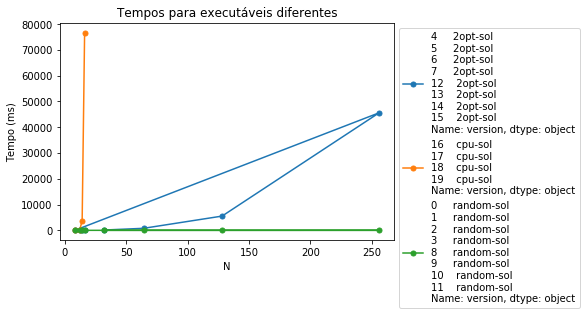

In [108]:
durations = df.groupby('version')
fig, ax = plt.subplots()
for name, group in durations:
    ax.plot(group.N, group.duration, marker='o', linestyle='-', ms=5, label=group.version)

plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('N')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()

In [124]:
df[df.version == 'random-sol'].describe().cost.mean()

137914.42151540826

In [125]:
df[df.version == '2opt-sol'].describe().cost.mean()

54848.14984115548

Podemos observar que na média, as soluções encontradas com o `random-sol` tiveram um custo médio de `137914.42`, enquanto as soluções encontradas com o `2opt-sol` um custo médio `54848.15`, ou seja, **~60% melhores!**


Os resultados de CPU foram péssimos quando comparados à GPU:

In [143]:
df[(df.N < 20) & ((df.version == 'random-sol') | (df.version == '2opt-sol'))].mean()

N              12.500000
cost        29977.289949
duration       10.521646
dtype: float64

In [145]:
df[df.version == 'cpu-sol'].mean()

N              12.500000
cost        26266.288267
duration    20143.500000
dtype: float64

Podemos observar que, com um custo médio marginalmente melhor na `CPU` (`26266`) por ser uma solução otima, ela levou um tempo médio de 20 segundos, enquanto as soluções em GPU levaram em média 10 millisegundos para encontrar soluções que embora não sejam as melhores, são satisfatórias.

Podemos também observar no gráfico que embora o tempo com a solução `2opt` cresça muito mais rápido com a entrada do que o random, ela produz resultados muito melhores, de forma que seja uma solução viável para a resolução do problema, pois mesmo com uma entrada considerável (256 pontos), ela levou "apenas" `45613.4 ms` = `45.6s`.

In [151]:
df[(df.version == '2opt-sol') & (df.N == 256)]

,N,cost,duration,path,version
7,256.0,77597.29498,45613.4,0 80 106 134 85 55 186 21 7 197 170 96 220 130...,2opt-sol


Logo, é possível concluir que o uso da GPU é uma ferramenta poderosissima para a resolução desse tipo de problema (NP hard), tornando as soluções em CPU irrisórias.